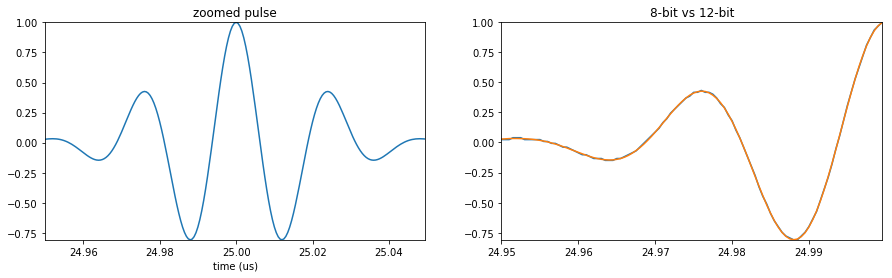

In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt


def digitize(x, n_bits, vert_range):
    xn = np.zeros(x.shape)
    v = np.linspace(-vert_range, vert_range, 2**n_bits)
    xn[x > vert_range] = vert_range
    xn[x < vert_range] = -vert_range
    for i in range(len(x)):
        d = np.abs(x[i] - v)
        xn[i] = v[np.argmin(d)]
    return xn

def plot_pulse(time_vector, pulse, zoomed_window_size):
   
    record_length = len(pulse)
    pulse_location = int(record_length/2)
    zoom_index_1 = pulse_location - int(zoomed_window_size/2)
    zoom_index_2 = pulse_location + int(zoomed_window_size/2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 4])

    ax1.plot(time_vector[zoom_index_1:zoom_index_2]*1e6, pulse[zoom_index_1:zoom_index_2])
    ax1.autoscale(enable=True, axis='both', tight=True)
    ax1.set_xlabel('time (us)')
    ax1.set_title('zoomed pulse')

    ax2.plot(time_vector[zoom_index_1:pulse_location]*1e6, 
             pulse_digitized_8[zoom_index_1:pulse_location])
    ax2.plot(time_vector[zoom_index_1:pulse_location]*1e6, 
             pulse_digitized_12[zoom_index_1:pulse_location])
    ax2.autoscale(enable=True, axis='both', tight=True)
    ax2.set_title('8-bit vs 12-bit')

    return fig   

# produce a guassian pulse in the center of a daq window of
# duration equal to daq_time
speed_sound = 1500 # m/s
sample_rate = 2e9  # sample rate strongly influences axial resolution of elastogram!
sample_period = 1/sample_rate
pulse_rep_freq = 20e3
pulse_period = 1/pulse_rep_freq  # note this should be < displacement_period
# make waveform length equal to time between pulses for simplicity
daq_time = pulse_period
time_vector = np.arange(-daq_time/2, daq_time/2, sample_period)
frequency_central = 40e6
pulse = signal.gausspulse(time_vector, fc=frequency_central)
time_vector += daq_time/2
record_length = len(time_vector)

# simulate digizer
pulse_digitized_8 = digitize(pulse, 8, 2)  # 8-bit signal with vertical range equal 2x the amp
pulse_digitized_12 = digitize(pulse, 12, 2) # 12-bit singal with vertical range equal 2x the amp

fig1 = plot_pulse(time_vector, pulse, 200)
fig1


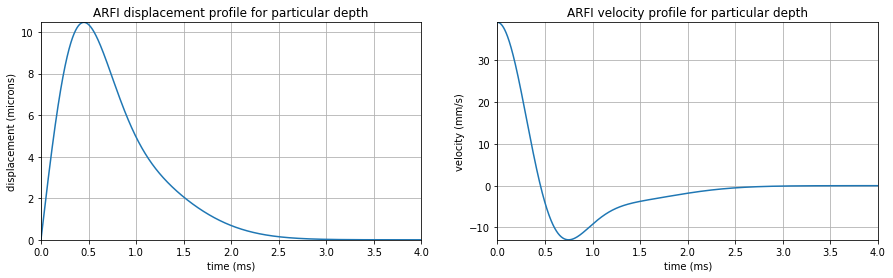

In [2]:
def rayleighs(x, sigma):
    f = x/sigma**2 * np.exp(-x**2/(2 * sigma**2))
    return f

def plot_disp_vel(profile_time, displacement_profile, velocity_profile):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,4])
    
    ax1.plot(profile_time*1e3, displacement_profile*1e6);
    ax1.autoscale(enable=True, axis='both', tight=True)
    ax1.set_xlabel('time (ms)')
    ax1.set_ylabel('displacement (microns)')
    ax1.set_title('ARFI displacement profile for particular depth')
    ax1.grid(True)

    ax2.plot(profile_time[0:-1]*1e3, velocity_profile*1e3)
    ax2.autoscale(enable=True, axis='both', tight=True)
    ax2.set_xlabel('time (ms)')
    ax2.set_ylabel('velocity (mm/s)')
    ax2.set_title('ARFI velocity profile for particular depth')
    ax2.grid(True)

    return fig

# build values with which to timeshift guassian pulse so as to mimic
# tracking of an ARF pulse. Model displacment as
# build displacement profile - should be a single cycle of an oscillatory
# waveform.

# note: you likely won't observe displacement exactly = max_displacement b/c
# you might not sample at the peak of displacement_prof

max_displacement = 5e-6  # meters (roughly)
displacement_profile_fs = sample_rate  # simpler if both have = sample period
profile_time = np.arange(0, 4e-3, 1/displacement_profile_fs)

# displacement modeled as the sum of two rayleigh functions
displacement_profile = rayleighs(profile_time * 1e3, 0.8) + rayleighs(profile_time * 1e3, 0.4) 
displacement_profile = max_displacement * displacement_profile  # units of meters

velocity_profile = np.diff(displacement_profile)*displacement_profile_fs # units of m/s

fig2 = plot_disp_vel(profile_time, displacement_profile, velocity_profile)
fig2

Doppler Scaling Factor = 0.9999479166666667


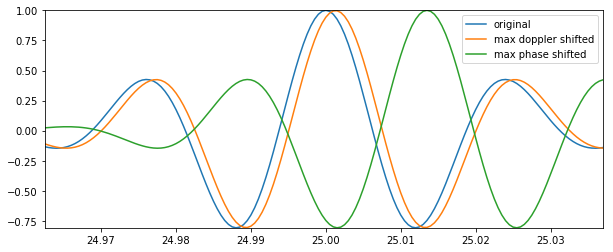

In [3]:
# demonstrate pulsed-wave doppler effect at maximum displacement velocity.
# see page 449 of Szabo, equation 11.11
# this is compared to the phase-shifted pulse at maximum displacement when 
# discounting the doppler effect. Cross-correlation analysis in cell below 
# does not take doppler effect into account (doppler effect is negligible?)

from scipy.interpolate import interp1d
from scipy.fftpack import fft


def plot_disp_dop(time_vector, pulse, pulse_shifted, pulse_doppler, zoomed_window_size):
    record_length = len(pulse)
    pulse_location = int(record_length/2)
    
    zoom_index_1 = pulse_location - int(zoomed_window_size/2)
    zoom_index_2 = pulse_location + int(zoomed_window_size/2)

    fig, ax1 = plt.subplots(1, 1, figsize=[10,4])
    ax1.plot(time_vector[zoom_index_1:zoom_index_2]*1e6, pulse[zoom_index_1:zoom_index_2],
             time_vector[zoom_index_1:zoom_index_2]*1e6, pulse_doppler[zoom_index_1:zoom_index_2],
             time_vector[zoom_index_1:zoom_index_2]*1e6, pulse_shifted[zoom_index_1:zoom_index_2])

    ax1.legend(('original', 'max doppler shifted', 'max phase shifted'))
    ax1.autoscale(enable=True, axis='both', tight=True)

    return fig

# determine shifted pulse due to displacement at maximum displacement
displacement = np.max(displacement_profile);  # m
timeshift = 2*displacement/speed_sound
indexshift = timeshift*sample_rate
pulse_shifted = np.roll(pulse, int(indexshift))

# determine modified pulse due to doppler effect at maximum velocity
doppler_velocity = np.max(velocity_profile)
obs_angle = 0  # movement is parallel with pulse propagation vector
time_delay_modifier = 2*doppler_velocity*np.cos(obs_angle)/speed_sound
doppler_scaling_factor = 1 - time_delay_modifier  #  11.11B
print('Doppler Scaling Factor = {}'.format(doppler_scaling_factor))

interp_func = interp1d(time_vector, pulse, kind='linear', bounds_error=False,
                           fill_value=1)
pulse_doppler = interp_func(time_vector * doppler_scaling_factor)

fig3 = plot_disp_dop(time_vector, pulse, pulse_shifted, pulse_doppler, zoomed_window_size=150)
fig3

[  0.00000000e+00   5.20833333e-05   1.04166667e-04 ...,   3.10557226e-04
   3.10556294e-04   3.10555363e-04]


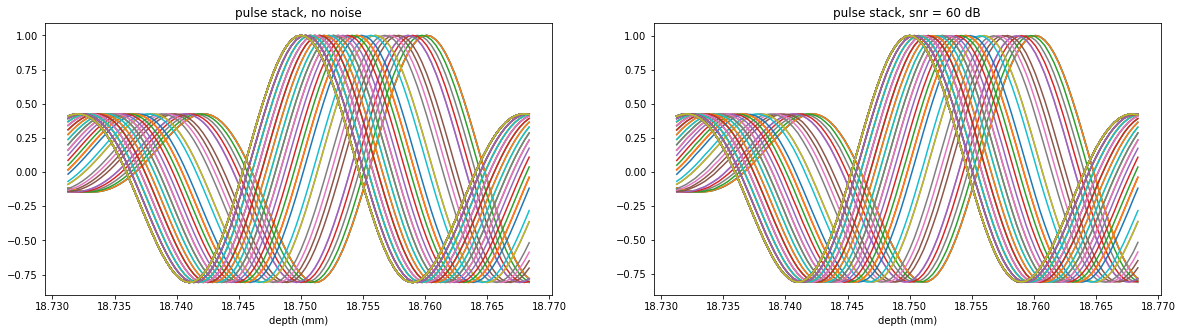

In [7]:
# construct pulse train of variably shifted pulses
# note displacement_period does not = 1/displacement_freq b/c you are only
# retrieving a half cycle as opposed to a full one

def add_noise(waveform, snr=60):
    ''' inputs - 
            signal - input signal (1-D numpy array)
            snr - desired signal snr in dB after adding noise
    '''
    # wvfm_rms = np.sqrt(np.mean(waveform**2))
    wvfm_rms = np.max(waveform)  # peak is used to represent rms b/c waveform is a single pulse
    std_dev = wvfm_rms/(10**(snr/20))
    noise = np.random.normal(0, std_dev, len(waveform))
    noisy_wvfm = waveform + noise   
    return noisy_wvfm


def plot_stacks(pulse, pulse_stack, pulse_stack_noise):
    
    depth = time_vector*speed_sound/2
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20,5])
 
    record_length = len(pulse)
    pulse_location = int(record_length/2)
    zoomed_window_size = 100
    zoom_index_1 = int(record_length/2) - int(zoomed_window_size/2)
    zoom_index_2 = int(record_length/2) + int(zoomed_window_size/2)

    ax1.plot(depth[zoom_index_1:zoom_index_2]*1e3, pulse_stack[zoom_index_1:zoom_index_2, :])
    ax1.set_xlabel('depth (mm)')
    ax1.set_title('pulse stack, no noise')

    ax2.plot(depth[zoom_index_1:zoom_index_2]*1e3, pulse_stack_noise[zoom_index_1:zoom_index_2, :])
    ax2.set_xlabel('depth (mm)')
    ax2.set_title('pulse stack, snr = ' + str(snr) + ' dB')

    return fig

# determine the number of indices by which signal will shift for each displacement value
timeshift_profile = 2*displacement_profile/speed_sound
indexshift_profile = timeshift_profile*sample_rate

print(indexshift_profile)

displacement_period = np.max(profile_time)
n_pulses_per_displacement = int(displacement_period/pulse_period) - 1
pulse_train = []  # list

pulse_dig = pulse # digitize(pulse, n_bits=8, vert_range=2)  # simulate digitizer

# for inserting jitter effects
jitter_mean = 0
jitter_std_dev = 0 # 100e-12 # combined jitter value from function generator and reference clock

# get pulse stack and noisy pulse stack. stack will have the pulses taken throughout the
# the displacement period plus the reference pulse
pulse_stack = np.zeros((record_length, n_pulses_per_displacement + 1))
pulse_stack_noise = pulse_stack.copy()
snr = 60
for n in range(n_pulses_per_displacement + 1):
    if n == 0:
        # add reference pulse to stack
        pulse_train.extend(pulse_dig)
        pulse_stack[:, n] = pulse_dig
        pulse_stack_noise[:, n] = add_noise(pulse_dig)
    else: 
        # add time-shifted pulses to stack
        window_indices = np.arange(record_length) + (n - 1) * record_length
        # choose the displacement value as the median value across the window
        indexshift = np.median(indexshift_profile[window_indices]) + np.random.normal(jitter_mean, 
                                                                                      jitter_std_dev)*sample_rate
        pulse_shifted = np.roll(pulse_dig, int(indexshift))
        pulse_train.extend(pulse_shifted)
        pulse_stack[:, n] = pulse_shifted
        pulse_stack_noise[:, n] = add_noise(pulse_shifted, snr)

fig4 = plot_stacks(pulse, pulse_stack, pulse_stack_noise)
fig4

pixel height is 0.375 um
wavelength is 37.5 um
correlation window size is 199.99999999999997 pixels
estimated dislacement is 4.875 um


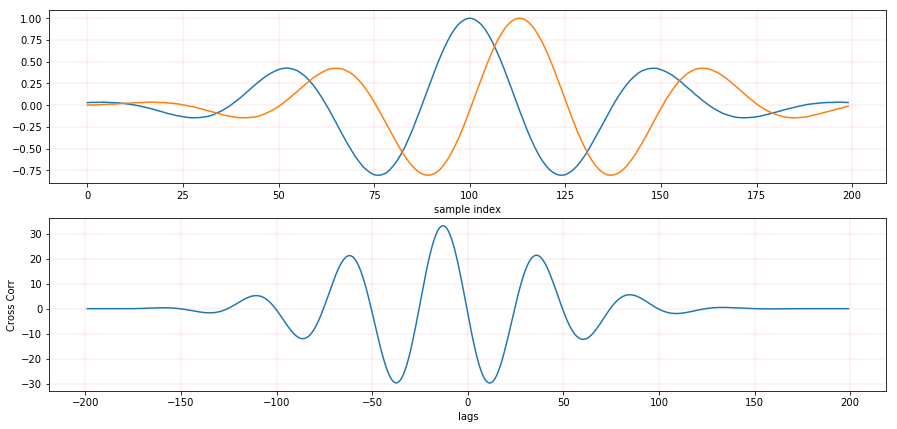

In [8]:
def plot_cc(reference_waveform, tracking_waveform):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 7))
    ax1.plot(reference_window)
    ax1.plot(tracking_window)
    ax1.grid(color='r', linestyle='-', linewidth=0.1)
    ax1.set_xlabel('sample index')
    ax2.plot(lags, cross_corr)
    ax2.set_xlabel('lags')
    ax2.set_ylabel('Cross Corr')
    ax2.grid(color='r', linestyle='-', linewidth=0.1)
    return fig


# Set up window sizes and other parameters for displacement tracking
# Suppose you want to want to estimate the displacement of a chunk of material at a 
# given time point, for which you have an entire waveform. Within that waveform you 
# have depth information, and the launch timepoint is the time of the displacement 
# profile that you are probing.

# If you take a subset of data from that waveform (window) and compare to the same 
# subset from a waveform acquired prior to the displacement, then you can get an 
# estimate for the displacement at a depth corresponding to the window
# location in the waveform. This comparison is done via cross-correlation. Let's 
# take two waveforms from our pulse-stack give it a shot.

# typically the window size is specified in number of wavelengths. let's get that value in pixels:
pixel_height = speed_sound/sample_rate/2
wavelength = speed_sound/frequency_central
n_wavelengths = 2
window_length   = n_wavelengths * wavelength/pixel_height
# now let's select a depth in the material at which to detect the displacement.
# the target is located in the middle i.e. the pulse location, so let's go with that
record_length = len(pulse)
pulse_location = int(record_length/2)

# select two waveforms from the pulse stack
reference_waveform = pulse_stack_noise[:, 0]  # first waveform
# let's choose tracking waveform acquired at a time corresponding to a quarter
# of the whole displacement period (4 ms/4 = 1 ms). remember, pulse stack as an added wavform
# for reference, hence + 1
tracking_waveform = pulse_stack_noise[:, int(n_pulses_per_displacement/4)+1]

# get windows from waveforms that correspoond to the chosen window depth. specifically 
# get a window centered at the designated depth
half_window_length  = round(window_length/2)
window_indices = pulse_location + np.arange(-half_window_length, half_window_length)
reference_window = reference_waveform[window_indices]
tracking_window = tracking_waveform[window_indices]

# now let's do corr-correlation of the two windows to estimate the displacement
cross_corr = np.correlate(reference_window, tracking_window, 'full')
lags = np.arange(-(len(reference_window)-1), len(reference_window))
lag_at_peak_cc = lags[np.argmax(cross_corr)]
corr_coef = np.corrcoef(reference_window, tracking_window)[0, 1]
displacement = lag_at_peak_cc*pixel_height
max_displacement = -np.max(displacement)

print('pixel height is {} um'.format(pixel_height*1e6))
print('wavelength is {} um'.format(wavelength*1e6))
print('correlation window size is {} pixels'.format(window_length))
print('estimated dislacement is {} um'.format(max_displacement*1e6))

fig5 = plot_cc(reference_window, tracking_window)        
fig5

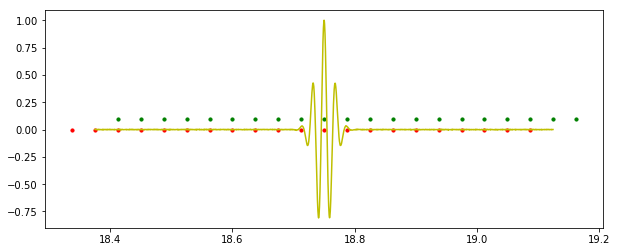

In [9]:
# okay, now that we've estimated the displacement at a given time point, let's do it for all
# timepoints in the dispalcement curve and try to reconstruct the curve. Further more, let's do it at 
# several depths. To do it at several depths, we need to select a window,  irst let's set up our windows.

# first choose the size of the entire target window which will get broken up into our analysis cc windows
# from before.
target_window_size = 2000 # scwindow_length * (n_windows - 1) # size of window over s
target_start_index = pulse_location - int(target_window_size/2)
target_end_index = pulse_location + int(target_window_size/2)

# traditionally, the windows are chosen with 50% overlap. let's get the number of windows that you'll need
# for your target window size and the location of the center of the those windows
n_windows = round((target_end_index - target_start_index)/half_window_length) + 1
target_depth = np.arange(target_start_index, target_end_index) * pixel_height
# center of windows used for depth estimation
window_depth_index = target_start_index + np.arange(n_windows) * half_window_length
window_depth = window_depth_index*pixel_height

# visualize the windows used for the analysis with respect to the entire target window.
# The red dots show the beginnging location of all windows, and the green show the end location for all windows.
# Part of the signal outside the target window will be used
# to get the displacement at the very beginning and end of the target window.
fig6, ax = plt.subplots(figsize=(10,4))
# # plot beginning of windows
ax.scatter((window_depth - half_window_length*pixel_height)*1e3, np.zeros(window_depth.shape), s=10, c='r')
# # plot ends of windows
ax.scatter((window_depth + half_window_length*pixel_height)*1e3, np.zeros(window_depth.shape)+0.1, s=10, c='g')
    # # ax4.title('first pulse and window boundaries')
ax.plot(target_depth*1e3, pulse_stack_noise[target_start_index:target_end_index, 0], c='y')
fig6

plotting displacment at 18.7498125 mm


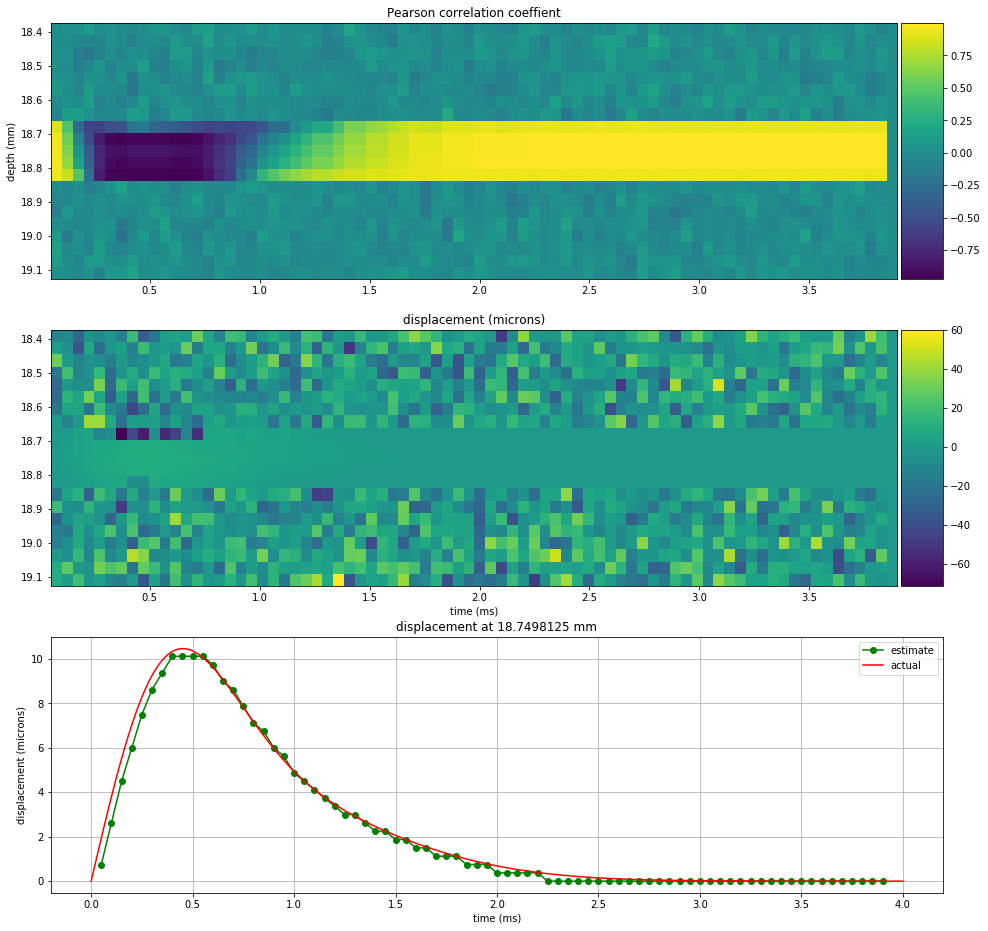

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_disp_track(argin):
    # retrieve inputs
    time = argin['time']; window_depth = argin['window_depth']; displacement = argin['displacement']
    displacement_profile = argin['displacement_profile']; profile_time = argin['profile_time']
    target_displacement = argin['target_displacement']; pixel_height = argin['pixel_height']
    half_window_length = argin['half_window_length']; corr_coef = argin['corr_coef']
    target_depth = argin['target_depth']; pulse_stack_noise = argin['pulse_stack_noise']
   
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[16,16])
    im1 = ax1.imshow(corr_coef, extent=(time[0]*1e3, time[-1]*1e3, window_depth[-1]*1e3, 
                                        window_depth[0]*1e3), aspect='auto')
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cbar1 = plt.colorbar(im1, cax=cax1)
    ax1.set_title('Pearson correlation coeffient')
    ax1.set_ylabel('depth (mm)')

    im2 = ax2.imshow(-displacement*1e6, extent=(time[0]*1e3, time[-1]*1e3, window_depth[-1]*1e3, 
                                                window_depth[0]*1e3), aspect='auto')
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    cbar2 = plt.colorbar(im2, cax=cax2)
    ax2.set_xlabel('time (ms)')
    ax2.set_title('displacement (microns)')

    ax3.plot(time*1e3, target_displacement*1e6, 'g-o', profile_time*1e3, displacement_profile*1e6, 
             'r')
    ax3.set_ylabel('displacement (microns)')
    ax3.set_xlabel('time (ms)')
    ax3.set_title('displacement at ' + str(depth_to_plot*1e3) + ' mm')
    ax3.grid(True)
    ax3.legend(['estimate', 'actual'])

    # # ax4.plot(window_depth*1e3, np.max(-displacement*1e6, axis=1), '-o')
    # # ax4.set_xlabel('Depth (mm)')
    # # ax4.set_ylabel('Maximum displacement (microns)')

 
    return fig


# this is selecting the window you want to use for reconstructing the curve. Obviously you want to choose
# a depth whitch falls near the main target in the center.
depth_to_plot = (np.max(target_depth) - np.min(target_depth))/2 + np.min(target_depth) # center of target window
print('plotting displacment at ' + str(depth_to_plot*1e3) + ' mm')
dtp_index = np.argmin(np.abs(window_depth - depth_to_plot))

# add 1 because there is no correlation result at t=0
time = (np.arange(n_pulses_per_displacement) + 1)*pulse_period  

target_displacement = np.zeros((len(time)))

corr_coef = np.zeros((n_windows, n_pulses_per_displacement))
lag_at_peak_cc = np.zeros((n_windows, n_pulses_per_displacement))

for k in range(n_windows):
    window_indices = target_start_index + np.arange(-half_window_length, 
                                                    half_window_length) + k * half_window_length    
    reference_window = pulse_stack_noise[window_indices, 0]
    reference_window /= np.max(reference_window)
    for i in range(n_pulses_per_displacement-1):
        tracking_window = pulse_stack_noise[window_indices, i + 1]
        tracking_window /= np.max(tracking_window)

        cross_corr = np.correlate(reference_window, tracking_window, 'full')
        lags = np.arange(-(len(reference_window)-1), len(reference_window))

        lag_at_peak_cc[k, i] = lags[np.argmax(cross_corr)]
        corr_coef[k, i] = np.corrcoef(reference_window, tracking_window)[0, 1]

        
# typically, values for displacement estimation are only kept if the R^2 value for the correlation
# is above some threshold. I've set it to zero for demonstration purposes. But clearly this is useful
# if you want to ignore estimates in windows for which there aren't any signals. Observe the displacement
# estimates outside of the region where the main target lies. They are all over the place.

R2_thresh = 0
indices_cc_nogood = np.where(corr_coef**2 < R2_thresh)
lag_at_peak_cc[indices_cc_nogood] = 0
corr_coef[indices_cc_nogood] = -1

# get final displacement values from cc results. It's conventional to interpolate the reconstructed displacement
# curve, but I haven't done that here.
displacement = lag_at_peak_cc*pixel_height
max_displacement = np.max(displacement, axis=1)
target_displacement = -displacement[dtp_index, :]

plot_inputs = {'time': time, 'window_depth':window_depth, 'corr_coef':corr_coef, 
               'displacement':displacement, 'profile_time':profile_time, 
               'target_displacement': target_displacement, 'pixel_height': pixel_height,
               'half_window_length': half_window_length, 'target_depth': target_depth, 
               'pulse_stack_noise': pulse_stack_noise, 'displacement_profile': displacement_profile}
fig6 = plot_disp_track(plot_inputs)
fig6
    
